# Modeling with Temporal (Chronological) Splits

This notebook uses proper temporal validation:
- Train on early time periods
- Validate on middle periods
- Test on recent periods

This prevents data leakage and provides realistic performance estimates.

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

In [13]:
# Load temporal features
feats = pd.read_parquet('../data/processed/intersection_features_temporal.parquet')

# Validation checks
assert 'cutoff_date' in feats.columns, "❌ Missing cutoff_date - wrong file?"
assert 'future_crashes' in feats.columns, "❌ Missing future_crashes for labels"
assert len(feats) > 100000, "❌ Too few samples"

print(f'✅ Data loaded successfully')
print(f'Shape: {feats.shape}')
print(f'Time periods: {feats["cutoff_date"].nunique()}')
print(f'Date range: {feats["cutoff_date"].min()} to {feats["cutoff_date"].max()}')
feats.head()

✅ Data loaded successfully
Shape: (399073, 33)
Time periods: 23
Date range: 2014-06-01 16:48:00 to 2025-04-04 16:48:00


,intersection_id,hist_crashes,hist_severity,hist_injuries_total,hist_injuries_fatal,hist_injuries_incapacitating,hist_injuries_nonincap,recent90_crashes,recent90_severity,recent90_injuries_total,recent90_injuries_fatal,recent90_injuries_incapacitating,recent90_injuries_nonincap,future_crashes,future_severity,cutoff_date,centrality_degree,centrality_closeness,centrality_betweenness,GEOID,acs_pop,acs_median_income,acs_households_with_vehicle,acs_poverty_universe,acs_vehicle_access_rate,community_id,community_name,label_hotspot,acs_pop_missing,acs_median_income_missing,acs_households_with_vehicle_missing,acs_poverty_universe_missing,acs_vehicle_access_rate_missing
0,261170646.0,1.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-06-01 16:48:00,0.000272,0.011248,0.000826,17031020602,5343.0,83839.0,223.0,5338.0,0.041737,2.0,WEST RIDGE,0,0,0,0,0,0
1,261219418.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2014-06-01 16:48:00,0.000204,0.016746,0.000772,17031691400,2701.0,38816.0,568.0,2701.0,0.210292,69.0,GREATER GRAND CROSSING,1,0,0,0,0,0
2,261220999.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-06-01 16:48:00,0.000272,0.017067,0.003625,17031837100,1515.0,48880.0,229.0,1515.0,0.151155,27.0,EAST GARFIELD PARK,0,0,0,0,0,0
3,287216684.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2014-06-01 16:48:00,0.000238,0.010929,0.002842,17031010503,2417.0,18750.0,769.0,2417.0,0.318163,1.0,ROGERS PARK,1,0,0,0,0,0
4,367989617.0,1.0,3.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2014-06-01 16:48:00,0.000204,0.013792,0.000429,17031431302,3788.0,32031.0,776.0,3788.0,0.204857,43.0,SOUTH SHORE,0,0,0,0,0,0


In [14]:
# Prepare features (drop leakage columns)
label_col = 'label_hotspot'
drop_cols = [
    'intersection_id',
    'community_name',
    'GEOID',
    'cutoff_date',  # Used for splitting, not as feature
    label_col,
    'future_crashes',
    'future_severity',
]

X = feats.drop(columns=drop_cols)
y = feats[label_col]
dates = feats['cutoff_date']

# Handle missing values
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median())

# Winsorize outliers
cap_cols = [
    'hist_injuries_total',
    'recent90_injuries_total',
    'hist_crashes',
    'recent90_crashes',
]
for c in cap_cols:
    if c in X.columns:
        upper = X[c].quantile(0.99)
        X[c] = X[c].clip(upper=upper)

# Critical: Check for data leakage
leakage_cols = [col for col in X.columns if 'future' in col.lower()]
assert len(leakage_cols) == 0, f"🚨 LEAKAGE DETECTED: {leakage_cols} in features!"

print(f'✅ No leakage detected')
print(f'Features shape: {X.shape}')
print(f'Positives: {y.sum()} of {len(y)} ({y.mean()*100:.2f}%)')
print(f'Missing values: {X.isna().sum().sum()} (after imputation)')

✅ No leakage detected
Features shape: (399073, 26)
Positives: 46385 of 399073 (11.62%)
Missing values: 0 (after imputation)


In [15]:
# Chronological split by cutoff_date
unique_dates = sorted(dates.unique())
n_periods = len(unique_dates)

train_end_idx = int(0.7 * n_periods)
val_end_idx = int(0.85 * n_periods)

train_dates = unique_dates[:train_end_idx]
val_dates = unique_dates[train_end_idx:val_end_idx]
test_dates = unique_dates[val_end_idx:]

train_mask = dates.isin(train_dates)
val_mask = dates.isin(val_dates)
test_mask = dates.isin(test_dates)

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f'Temporal Split:')
print(f'  Train: {train_dates[0].date()} to {train_dates[-1].date()} ({len(X_train)} samples)')
print(f'  Val:   {val_dates[0].date()} to {val_dates[-1].date()} ({len(X_val)} samples)')
print(f'  Test:  {test_dates[0].date()} to {test_dates[-1].date()} ({len(X_test)} samples)')
# Verify temporal integrity (no overlap)
assert train_dates[-1] < val_dates[0], "🚨 Train/val temporal overlap!"
assert val_dates[-1] < test_dates[0], "🚨 Val/test temporal overlap!"
print('✅ Temporal integrity verified - no overlap between splits')

print(f'\nClass distribution:')
print(f'  Train: {y_train.mean()*100:.1f}% positive')
print(f'  Val:   {y_val.mean()*100:.1f}% positive')
print(f'  Test:  {y_test.mean()*100:.1f}% positive')

Temporal Split:
  Train: 2014-06-01 to 2021-10-22 (248913 samples)
  Val:   2022-04-20 to 2023-04-15 (64401 samples)
  Test:  2023-10-12 to 2025-04-04 (85759 samples)
✅ Temporal integrity verified - no overlap between splits

Class distribution:
  Train: 11.5% positive
  Val:   11.5% positive
  Test:  12.0% positive


In [16]:
def eval_model(model, X_tr, y_tr, X_va, y_va, name: str):
    model.fit(X_tr, y_tr)
    val_proba = model.predict_proba(X_va)[:, 1]
    pr_auc = average_precision_score(y_va, val_proba)
    roc = roc_auc_score(y_va, val_proba)
    f1_default = f1_score(y_va, (val_proba >= 0.5).astype(int))
    
    precision, recall, thresh = precision_recall_curve(y_va, val_proba)
    f1s = 2 * (precision * recall) / (precision + recall + 1e-9)
    best_idx = np.nanargmax(f1s)
    best_f1 = f1s[best_idx]
    best_thresh = thresh[best_idx] if best_idx < len(thresh) else 0.5
    
    return {
        'model': name,
        'pr_auc': pr_auc,
        'roc_auc': roc,
        'f1@0.5': f1_default,
        'best_f1': best_f1,
        'best_thresh': best_thresh,
    }

In [17]:
# Train models
results = []

print('Training Logistic Regression...')
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=200, class_weight='balanced', n_jobs=-1)
)
results.append(eval_model(log_reg, X_train, y_train, X_val, y_val, 'Logistic'))

print('Training Random Forest...')
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42,
)
results.append(eval_model(rf, X_train, y_train, X_val, y_val, 'RandomForest'))

print('Training Gradient Boosting...')
gb = GradientBoostingClassifier(random_state=42)
results.append(eval_model(gb, X_train, y_train, X_val, y_val, 'GradientBoosting'))

results_df = pd.DataFrame(results).sort_values('pr_auc', ascending=False)
print('\nValidation Results:')
results_df

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...

Validation Results:


,model,pr_auc,roc_auc,f1@0.5,best_f1,best_thresh
2,GradientBoosting,0.769007,0.947432,0.666717,0.686258,0.365899
0,Logistic,0.762415,0.945387,0.591025,0.684051,0.806187
1,RandomForest,0.753971,0.941975,0.652745,0.674554,0.340000


In [18]:
# Evaluate best model on test set
best_name = results_df.iloc[0]['model']
models = {
    'Logistic': log_reg,
    'RandomForest': rf,
    'GradientBoosting': gb,
}
best_model = models[best_name]

# Retrain on train+val
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])
best_model.fit(X_trainval, y_trainval)

# Test predictions
test_proba = best_model.predict_proba(X_test)[:, 1]
pr_auc_test = average_precision_score(y_test, test_proba)
roc_test = roc_auc_score(y_test, test_proba)

# Find best threshold
precision, recall, thresh = precision_recall_curve(y_test, test_proba)
f1s = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.nanargmax(f1s)
best_f1_test = f1s[best_idx]
best_thresh_test = thresh[best_idx] if best_idx < len(thresh) else 0.5

best_preds = (test_proba >= best_thresh_test).astype(int)
precision_test = precision_score(y_test, best_preds)
recall_test = recall_score(y_test, best_preds)
cm = confusion_matrix(y_test, best_preds)

print(f'\n✅ Test Set Performance ({best_name}, threshold={best_thresh_test:.3f}):')
print(f'  PR-AUC:    {pr_auc_test:.3f}')
print(f'  ROC-AUC:   {roc_test:.3f}')
print(f'  F1:        {best_f1_test:.3f}')
print(f'  Precision: {precision_test:.3f}')
print(f'  Recall:    {recall_test:.3f}')
print(f'\nConfusion Matrix:')
print(f'  TN={cm[0,0]}, FP={cm[0,1]}')
print(f'  FN={cm[1,0]}, TP={cm[1,1]}')


✅ Test Set Performance (GradientBoosting, threshold=0.377):
  PR-AUC:    0.772
  ROC-AUC:   0.946
  F1:        0.691
  Precision: 0.676
  Recall:    0.708

Confusion Matrix:
  TN=71961, FP=3500
  FN=3007, TP=7291


In [19]:
# Feature importance
from sklearn.pipeline import Pipeline

est = best_model[-1] if isinstance(best_model, Pipeline) else best_model

if hasattr(est, "feature_importances_"):
    feat_imp = pd.Series(est.feature_importances_, index=X.columns).sort_values(ascending=False)
elif hasattr(est, "coef_"):
    feat_imp = pd.Series(est.coef_[0], index=X.columns).abs().sort_values(ascending=False)
else:
    feat_imp = pd.Series(dtype=float)

# Final leakage check
future_in_features = [col for col in feat_imp.index if 'future' in col.lower()]
if future_in_features:
    print(f"🚨 LEAKAGE: {future_in_features} in feature importance!")
else:
    print('✅ No future columns in feature importance')

print('\nTop 15 Features:')
feat_imp.head(15)

✅ No future columns in feature importance

Top 15 Features:


hist_crashes                    0.900140
recent90_crashes                0.033379
hist_injuries_total             0.023678
centrality_degree               0.011592
centrality_betweenness          0.008242
acs_households_with_vehicle     0.006532
recent90_injuries_total         0.003984
centrality_closeness            0.003358
acs_vehicle_access_rate         0.002309
acs_median_income               0.001522
hist_severity                   0.001056
hist_injuries_nonincap          0.000751
community_id                    0.000666
acs_poverty_universe            0.000603
acs_poverty_universe_missing    0.000572
dtype: float64

In [20]:
# Create results directory
import os
os.makedirs('../results', exist_ok=True)
print('Results directory ready')

Results directory ready


Saved: results/temporal_model_results.png


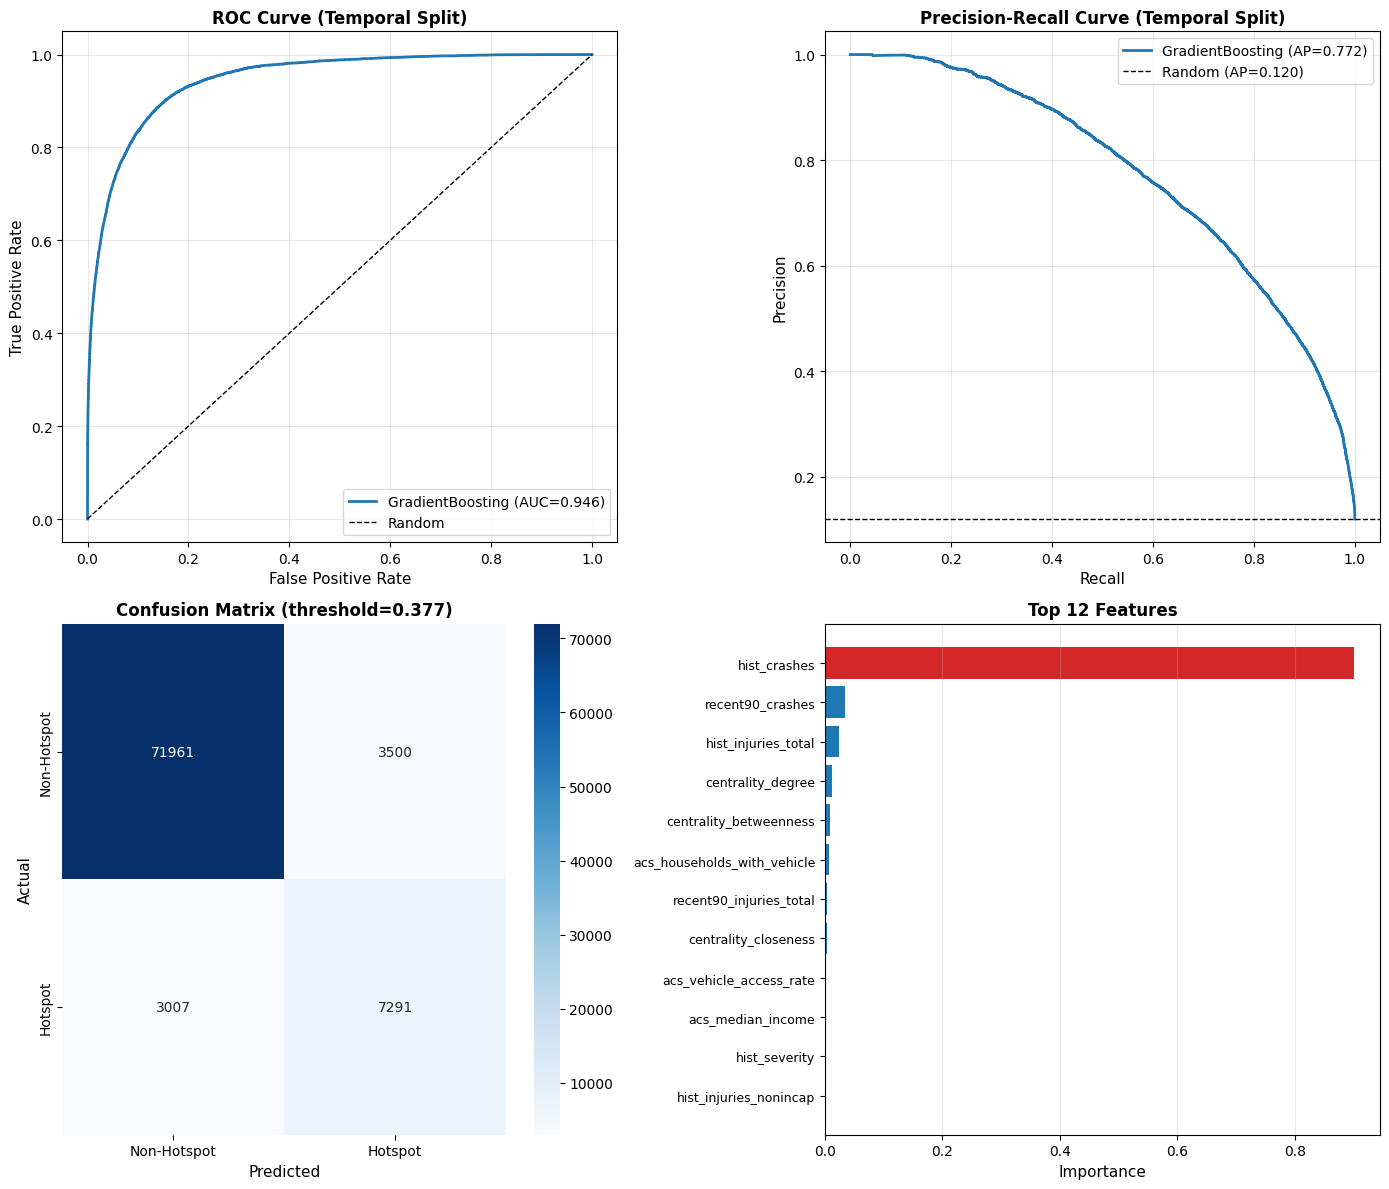

In [21]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'{best_name} (AUC={roc_test:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[0, 0].set_title('ROC Curve (Temporal Split)', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. PR Curve
baseline = y_test.mean()
axes[0, 1].plot(recall, precision, linewidth=2, label=f'{best_name} (AP={pr_auc_test:.3f})')
axes[0, 1].axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Random (AP={baseline:.3f})')
axes[0, 1].set_xlabel('Recall', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision-Recall Curve (Temporal Split)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Non-Hotspot', 'Hotspot'],
            yticklabels=['Non-Hotspot', 'Hotspot'])
axes[1, 0].set_xlabel('Predicted', fontsize=11)
axes[1, 0].set_ylabel('Actual', fontsize=11)
axes[1, 0].set_title(f'Confusion Matrix (threshold={best_thresh_test:.3f})', fontsize=12, fontweight='bold')

# 4. Feature Importance
top_features = feat_imp.head(12)
colors = ['#d62728' if i == 0 else '#1f77b4' for i in range(len(top_features))]
axes[1, 1].barh(range(len(top_features)), top_features.values, color=colors)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features.index, fontsize=9)
axes[1, 1].set_xlabel('Importance', fontsize=11)
axes[1, 1].set_title('Top 12 Features', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('../results/temporal_model_results.png', dpi=300, bbox_inches='tight')
print('Saved: results/temporal_model_results.png')
plt.show()

In [22]:
# Save results
results_df.to_csv('../results/temporal_model_comparison.csv', index=False)

test_metrics = pd.DataFrame([{
    'model': best_name,
    'split_type': 'temporal_chronological',
    'pr_auc': pr_auc_test,
    'roc_auc': roc_test,
    'best_f1': best_f1_test,
    'best_threshold': best_thresh_test,
    'precision': precision_test,
    'recall': recall_test,
    'tn': cm[0,0],
    'fp': cm[0,1],
    'fn': cm[1,0],
    'tp': cm[1,1],
}])
test_metrics.to_csv('../results/temporal_test_metrics.csv', index=False)

feat_imp.to_csv('../results/temporal_feature_importance.csv', header=['importance'])

print('✅ All results saved to results/ directory')

✅ All results saved to results/ directory


## Summary

This notebook implements **proper temporal validation** by:
1. Creating features for multiple time periods
2. Splitting chronologically (train on past, test on future)
3. Preventing data leakage

### Comparison with Random Split

Compare these results with the random split notebook to see:
- How much performance drops with realistic validation
- Whether feature importance changes
- If the model generalizes to future time periods

### For Your Paper

Use these results as your **main findings**. The temporal split is methodologically correct and provides realistic performance estimates for deployment.